In [1]:
from cluster import *
from load_data import *
from matplotlib import pyplot as plt
import sklearn, torch, random, numpy as np, pickle
from sklearn.model_selection import train_test_split
from classes import *

seed_num = 1
torch.manual_seed(seed_num)
np.random.seed(seed_num) #also sets sklearn seed
random.seed(seed_num)

In [2]:
file = '../Data/stations.dat'
if not isfile(file):
    save_stations(file)
station_id, coord, groups, points = cluster(file)
coord, points = np.array(coord), np.array(points)

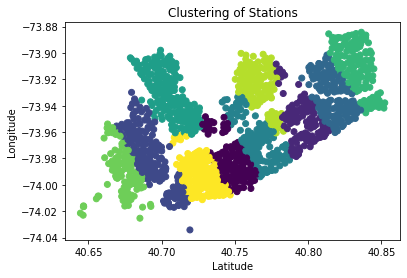

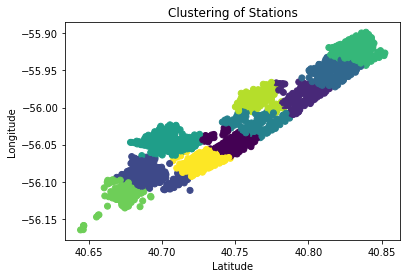

In [3]:
plt.scatter(coord[:, 0], coord[:, 1], c=groups)
plt.title('Clustering of Stations')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.savefig('../Graphs/Cluster.png')
plt.show()

plt.scatter(points[:, 0], points[:, 1], c=groups)
plt.title('Clustering of Stations')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.savefig('../Graphs/Cluster2.png')
plt.show()

In [4]:
file = '../Data/data.dat'
if isfile(file):
    with open(file, 'rb') as f:
        data = pickle.load(f)
else:
    try:
        data = load({station_id[i]: groups[i] for i in range(len(station_id))}, file)
    except FileNotFoundError:
        raise FileNotFoundError('Install the Citi Bike trip data for Jun 2013 to Jan 2021')

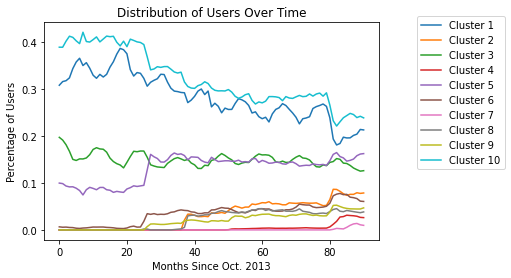

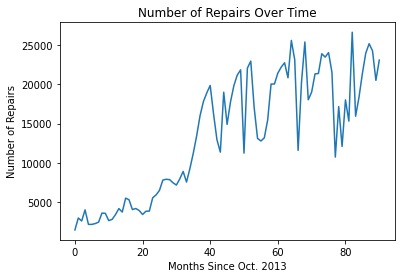

In [5]:
x, y, y2 = data
np_data = np.array(y2)

dates = []
for i in x:
    dates.append((i[0]-2013)*12+i[1]-6)
for i in range(10):
    plt.plot(dates, np_data[:, i], label="Cluster "+str(i+1))
plt.title("Distribution of Users Over Time")
plt.xlabel("Months Since Oct. 2013")
plt.ylabel("Percentage of Users")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.savefig("../Graphs/Task 1.png")
plt.show()

np_data = np.array(y)
plt.plot(dates, np_data[:, 0])
plt.title("Number of Repairs Over Time")
plt.xlabel("Months Since Oct. 2013")
plt.ylabel("Number of Repairs")
plt.savefig("../Graphs/Task 2.png")
plt.show()

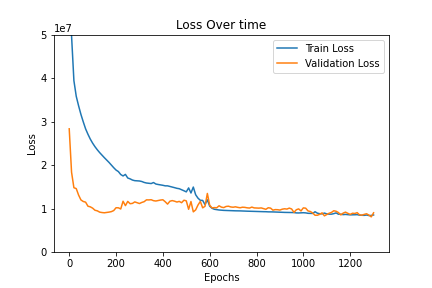

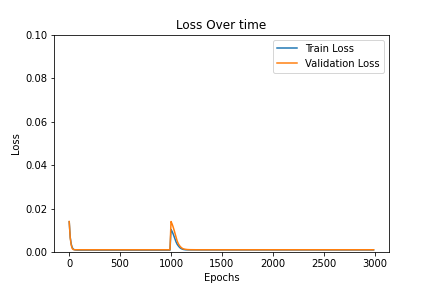

In [6]:
x, y, y2 = torch.tensor(x).float(), torch.tensor(y).float(), torch.tensor(y2).float()
x_train, x_test, y_train, y_test, y2_train, y2_test = train_test_split(x, y, y2, random_state=seed_num)
x_train, x_val, y_train, y_val, y2_train, y2_val = train_test_split(x_train, y_train, y2_train, random_state=seed_num)

REPAIR_NN = [10]*35
DEMAND_NN = [10]*30

repair = NN.init(len(x_train[0]), len(y_train[0]), REPAIR_NN, '../Data/repair.pt', '../Graphs/Repair.png', (x_train, y_train), (x_val, y_val), 5e7, 7500)

demand = NN.init(len(x_train[0]), len(y2_train[0]), DEMAND_NN, '../Data/demand.pt', '../Graphs/Demand.png', (x_train, y2_train), (x_val, y2_val), .1, 3000, demand=True)

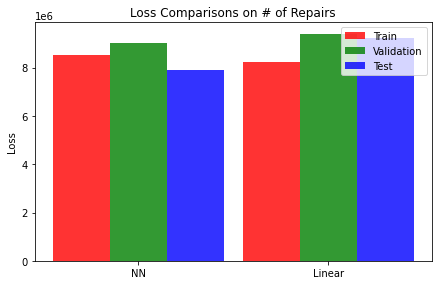

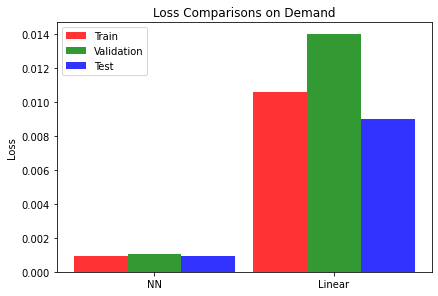

In [7]:
repair_linear = LinearRegression().fit(x_train, y_train)

demand_linear = MultiOutputLinear()
demand_linear.fit(x_train, y2_train)
loss_plot(repair, repair_linear, [(x_train, y_train, y2_train), (x_val, y_val, y2_val), (x_test, y_test, y2_test)],
            '../Graphs/repair_loss.png', 'Loss Comparisons on # of Repairs', ('NN', 'Linear'))
loss_plot(demand, demand_linear, [(x_train, y_train, y2_train), (x_val, y_val, y2_val), (x_test, y_test, y2_test)],
            '../Graphs/demand_loss.png', 'Loss Comparisons on Demand', ('NN', 'Linear'), y=2)

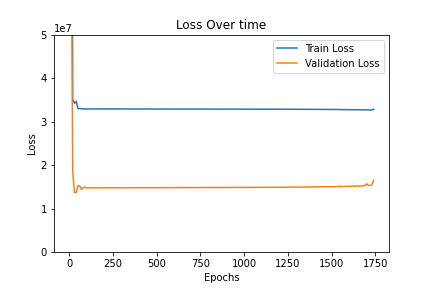

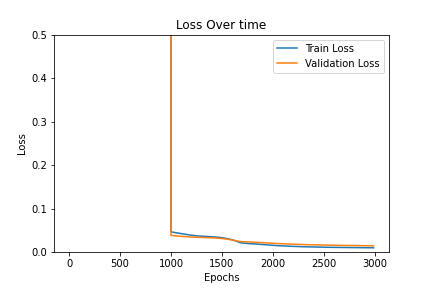

In [8]:
x_train2 = torch.tensor([i[:2] + [sum(i[2:12])] + i[12:] for i in x_train.tolist()])
x_val2 = torch.tensor([i[:2]+[sum(i[2:12])]+i[12:] for i in x_val.tolist()])
x_test2 = torch.tensor([i[:2]+[sum(i[2:12])]+i[12:] for i in x_test.tolist()])

repair2 = NN.init(len(x_train2[0]), len(y_train[0]), REPAIR_NN, '../Data/repair2.pt', '../Graphs/Repair2.png', (x_train2, y_train), (x_val2, y_val), 5e7, 7500)

demand2 = NN.init(len(x_train2[0]), len(y2_train[0]), DEMAND_NN, '../Data/demand2.pt', '../Graphs/Demand2.png', (x_train2, y2_train), (x_val2, y2_val), .5, 3000, demand=True)

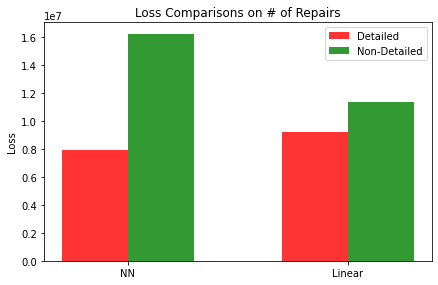

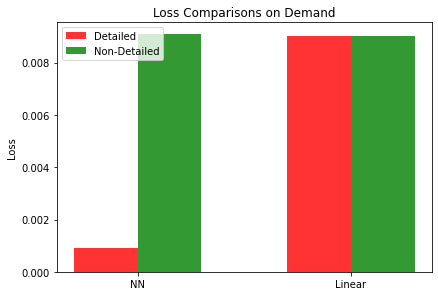

In [9]:
repair_linear2 = LinearRegression().fit(x_train2, y_train)
demand_linear2 = MultiOutputLinear()
demand_linear2.fit(x_train2, y2_train)

loss = nn.MSELoss()
index = np.arange(2)
losses = [(float(loss(repair(x_test), y_test)), float(loss(from_numpy(repair_linear.predict(x_test)), y_test))), 
        (float(loss(repair2(x_test2), y_test)), float(loss(from_numpy(repair_linear2.predict(x_test2)), y_test)))]
for i, c, l in [(0, 'r', 'Detailed'), (1, 'g', 'Non-Detailed')]:
    plt.bar(index+i*0.3, losses[i], 0.3, alpha=0.8, color=c, label=l)
plt.xticks(index + 0.15, ("NN", "Linear"))
plt.legend()
plt.tight_layout()
plt.title("Loss Comparisons on # of Repairs")
plt.ylabel('Loss')
plt.savefig("../Graphs/Repair_detailed.png")
plt.show()

loss = nn.MSELoss()
index = np.arange(2)
losses = [(float(loss(demand(x_test), y2_test)), float(loss(demand_linear.predict(x_test), y2_test))), 
        (float(loss(demand2(x_test2), y2_test)), float(loss(demand_linear2.predict(x_test2), y2_test)))]
for i, c, l in [(0, 'r', 'Detailed'), (1, 'g', 'Non-Detailed')]:
    plt.bar(index+i*0.3, losses[i], 0.3, alpha=0.8, color=c, label=l)
plt.xticks(index + 0.15, ("NN", "Linear"))
plt.legend()
plt.tight_layout()
plt.title("Loss Comparisons on Demand")
plt.ylabel('Loss')
plt.savefig("../Graphs/Demand_detailed.png")
plt.show()

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

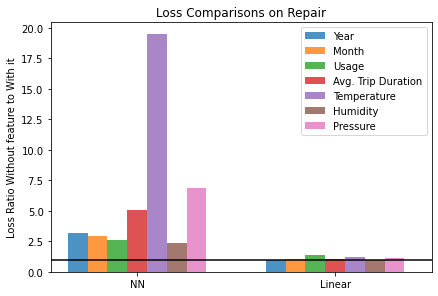

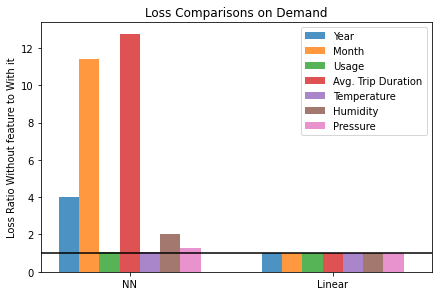

In [10]:
loss1 = []
loss2 = []
for n in list(range(3))+list(range(12, 16)):
    if n == 2:
        x_train2 = torch.tensor([i[:2]+i[12:] for i in x_train.tolist()])
        x_val2 = torch.tensor([i[:2]+i[12:] for i in x_val.tolist()])
        x_test2 = torch.tensor([i[:2]+i[12:] for i in x_test.tolist()])
    else:
        x_train2 = torch.tensor([i[:n] + i[n+1:] for i in x_train.tolist()])
        x_val2 = torch.tensor([i[:n] + i[n+1:] for i in x_val.tolist()])
        x_test2 = torch.tensor([i[:n] + i[n+1:] for i in x_test.tolist()])

    repair2 = NN.init(len(x_train2[0]), len(y_train[0]), REPAIR_NN, f'../Data/Feautures Removed/repair{n}.pt', None,
    (x_train2, y_train), (x_val2, y_val), 5e7, 7500)

    demand2 = NN.init(len(x_train2[0]), len(y2_train[0]), DEMAND_NN, f'../Data/Feautures Removed/demand{n}.pt', None, 
    (x_train2, y2_train), (x_val2, y2_val), .5, 3000, demand=True)

    repair_linear2 = LinearRegression().fit(x_train2, y_train)
    demand_linear2 = MultiOutputLinear()
    demand_linear2.fit(x_train2, y2_train)

    loss1.append((float(loss(repair2(x_test2), y_test))/float(loss(repair(x_test), y_test)), 
                float(loss(from_numpy(repair_linear2.predict(x_test2)), y_test))/float(loss(from_numpy(repair_linear.predict(x_test)), y_test))))
    loss2.append((float(loss(demand2(x_test2), y2_test))/float(loss(demand(x_test), y2_test)), 
                float(loss(demand_linear2.predict(x_test2), y2_test))/float(loss(demand_linear.predict(x_test), y2_test))))
index = np.arange(2)
width = 0.1
plt.close()
for li, n in [(loss1, "Repair"), (loss2, "Demand")]:
    for i, l in enumerate(["Year", "Month", "Usage", "Avg. Trip Duration", "Temperature", "Humidity", "Pressure"]):
        plt.bar(index+i*width, li[i], width, alpha=0.8, label=l)
    plt.xticks(index + 3*width, ("NN", "Linear"))
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.title("Loss Comparisons on "+n)
    plt.ylabel('Loss Ratio Without feature to With it')
    plt.axline((0, 1), (width*14+0.3, 1), c=(0, 0, 0))
    plt.savefig(f"../Graphs/{n}_Feature_loss.png")
    plt.show()

In [11]:
print(y_test[0].tolist())
print(repair(x_test)[0].tolist())
print(repair_linear.predict(x_test)[0])
print()
print(y2_test[0].tolist())
print(demand(x_test)[0].tolist())
print(demand_linear.predict(x_test)[0].tolist())

[20060.0]
[19474.38671875]
[20327.5]

[0.2513054311275482, 0.053999561816453934, 0.15692991018295288, 0.00311832083389163, 0.1520978808403015, 0.041311997920274734, 0.0, 0.042816899716854095, 0.03046363778412342, 0.26795637607574463]
[0.2791234254837036, 0.03330715373158455, 0.15110495686531067, 0.016861220821738243, 0.13138337433338165, 0.016861220821738243, 0.016861220821738243, 0.016861220821738243, 0.016861220821738243, 0.3207748234272003]
[0.11528518795967102, 0.09485669434070587, 0.10466302186250687, 0.09045891463756561, 0.10505929589271545, 0.09421712160110474, 0.09007459878921509, 0.09388614445924759, 0.09284935146570206, 0.11864971369504929]
